In [52]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive mode

In [53]:
# We take a single image name and its annoations from the CSV.
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65 # index from data/faces/face_landmarks.csv.
img_name = landmarks_frame.iloc[n, 0]

# Each face has landmarks. We use them for further processing.
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


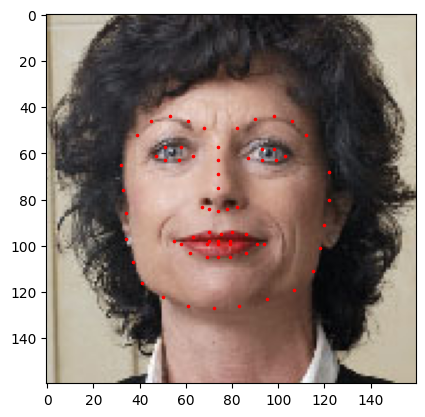

In [54]:
# Simple helper function that shows an image and its landmarks
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)

plt.show()

# Dataset class
We create a class that represents our data. We also need to impelement the
methods `__len__()` and `__getitem__()`. This abstraction lets us work with the
dataset easier.

In [55]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
        """
        self.landmarks_frame = pd.read_csv(csv_file)

        # If root_dir doesn't end with '/', then append it
        self.root_dir = root_dir
        if len(self.root_dir) > 0 and self.root_dir[-1] != '/':
            self.root_dir = self.root_dir + '/'

        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        """
        Arguments:
            idx (int): Index in the dataset csv annotations
        """
        if torch.is_tensor(idx):
            idx = idx.to_list()
        
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])

        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype='float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
        

0 (324, 215, 3) (68, 2)


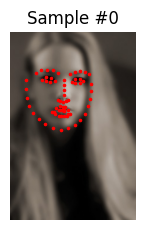

1 (500, 333, 3) (68, 2)


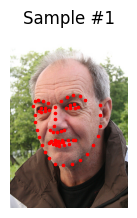

2 (250, 258, 3) (68, 2)


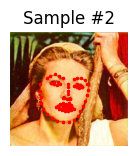

3 (434, 290, 3) (68, 2)


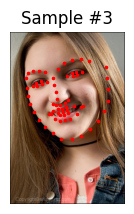

In [56]:
# instantiate FaceLandmarksDataset and view the first samples and their landmarks
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# Transforms
Most neural networks expect images of a fixed size. Ours aren't, so we need to
preprocess them with trnasformers.

In [57]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # Swap axes so x becomes y and vise versa
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


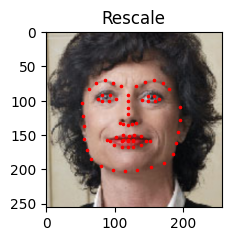

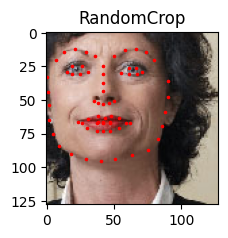

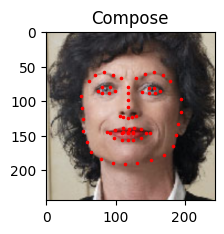

In [58]:
# Apply the transforms on a sample
# We can apply multiple transforms, similar to what we would do in computer
# graphics with translation, rotation, scale and shear.

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(244)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [62]:
# Iterate through the dataset and perform data augmentation on each image
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


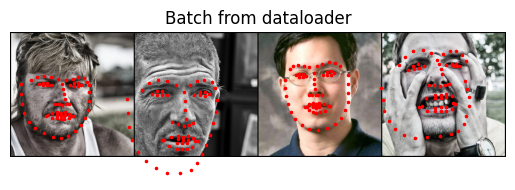

In [68]:
## Include batching and shuffling the data, and loading using multiprocessing
## workers

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        
        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop
# you might need to go back and change the num_workers to 0

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Afterword from PyTorch: torchvision

In this tutorial, we have seen how to write and use datasets, transforms and dataloader. `torchvision` package provides some common datasets and transforms. You might not even have to write custom classes. One of the more generic datasets available in torchvision is `ImageFolder`. It assumes that images are organized in the following way:
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

where ‘ants’, ‘bees’ etc. are class labels. Similarly generic transforms which operate on `PIL.Image` like `RandomHorizontalFlip`, `Scale`, are also available. You can use these to write a dataloader like this:

```python
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
```